In [10]:
from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
from mnist_cnn.mnistDatasetLoader import MnistDatasetLoader
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.nn import dilation2d
from tensorflow.nn import erosion2d

In [11]:
simplifiedModelPath = 'mnist_gan/simplifiedGan200Epochs/'
genPath = simplifiedModelPath + 'mnist_gen'
discPath = simplifiedModelPath + 'mnist_disc'
batchSize = 256
epochs = 200
gan = MnistGan(simplifiedDiscriminator = True)
cnn = MnistCnn()
cnn.loadWeights('mnist_cnn/MnistCnnTEST')
datasetLoader = MnistDatasetLoader()
dataset = datasetLoader.loadDataset(batchSize)

if(os.path.exists(simplifiedModelPath)):
    gan.loadWeights(genPath, discPath)
else:
    gan.train(dataset, epochs, batchSize, 25, verbose = True)
    gan.saveModel(genPath, discPath, overwrite = True)

gan.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1024      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 1)           1024      
_________________________________________________________________
flatten (Flatten)            (None, 49)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50        
Total params: 2,354
Trainable params: 2,226
Non-trainable params: 128
__________________________________________________

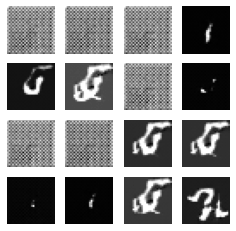

In [12]:
genExample = gan.generator(tf.random.normal([16,100]), training = False)
fig = plt.figure(figsize = (4,4))
for i in range(genExample.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(genExample[i,:,:,0], cmap = 'gray')
    plt.axis('off')

In [13]:
@tf.function
def g(x, index, classifier, discriminator):
    res = tf.math.log(discriminator(x)) - tf.math.log(tf.squeeze(classifier(x))[index])
    return res

def explain(x, classifier, discriminator, maxIter, maxChange, minAlpha):
    epsilon = 1e-16
    closeEnough = False
    iter = 0
    index = tf.argmax(tf.squeeze(classifier(x))).numpy()
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            gRes = g(x, index, classifier, discriminator)
        grad = tape.gradient(gRes, x)
        maxGrad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(minAlpha, maxChange/tf.maximum(maxGrad, epsilon))
        x.assign(x + alpha * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if ((newIndex != index) and (discriminator(x).numpy() > 0)): # done when the prediction has changed
            closeEnough = True
    print("done after ", iter, " steps")

(1, 28, 28, 1)
origY:  [1.5554316e-06 2.8286720e-11 1.4822335e-07 2.2620856e-07 2.2480552e-07
 8.8613910e-05 9.9928588e-01 9.2691545e-13 6.2343309e-04 1.4207899e-10]
origP:  [[0.9249538]]
done after  179  steps
newY:  [3.0716852e-04 3.8476369e-10 2.2167676e-04 5.0536369e-04 2.4113737e-05
 1.0744263e-03 4.1082391e-01 7.2862325e-09 5.8704311e-01 1.7917620e-07]
newP:  [[0.9673748]]


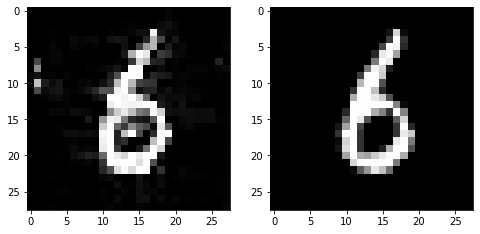

In [14]:
realImg = np.expand_dims(dataset.as_numpy_iterator().next()[0][0], 0)
x_ = tf.cast(realImg, tf.float32)
x = tf.Variable(x_)
print(x.shape)
origY = cnn.predict(x).numpy().squeeze()
origP = gan.discriminator(x).numpy()
print("origY: ", origY)
print("origP: ", origP)

explain(x, cnn.model, gan.discriminator, maxIter = 600, maxChange = 0.099, minAlpha = 100)

newY = cnn.predict(x).numpy().squeeze()
newP = gan.discriminator(x).numpy()
print("newY: ", newY)
print("newP: ", newP)

_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x[0], cmap = 'gray')
ax[1].imshow(realImg[0], cmap = 'gray')

In [15]:
def opening(img, structuring_element):
    erosion = erosion2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = dilation2d(erosion, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

def closing(img, structuring_element):
    dilation = dilation2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = erosion2d(dilation, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

In [16]:
new_x = tf.Variable(x)
print(new_x.dtype)
structuring_element = tf.ones((2,2,1))
output = opening(new_x, structuring_element)

<dtype: 'float32'>


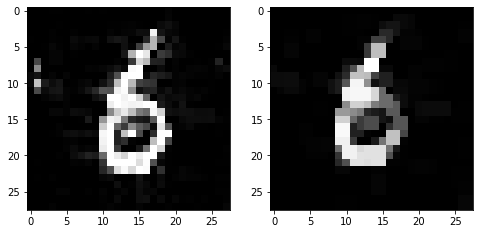

In [17]:
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x[0], cmap = 'gray')
ax[1].imshow(output[0], cmap = 'gray')